In [ ]:
# Install required packages
!pip install torch torchvision transformers datasets matplotlib pandas scikit-learn wordcloud
!pip install --upgrade --force-reinstall fsspec datasets

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)
  Using cached datasets-3.6.0-py3-none-any.whl.metadata (19 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached numpy-2.3.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached pyarrow-20.0.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached pandas-2.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (91 kB)
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached xxhash-3.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached huggingface_hub-0.33.2-py3-none-any.whl.metadata (14 kB)
  Using cached packaging-25.0-py

In [ ]:
# --- IMPORTS ---
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

In [ ]:
# --- PLOT STYLE ---
plt.style.use('seaborn-v0_8-bright')

# --- DEVICE SETUP ---
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", dev)


Device: cuda


In [ ]:
# --- LOAD AG NEWS DATASET ---
news_raw = load_dataset("ag_news")
news_df = pd.concat([pd.DataFrame(news_raw['train']), pd.DataFrame(news_raw['test'])], ignore_index=True)
news_df = news_df.sample(frac=1, random_state=321).reset_index(drop=True)

# --- FOR QUICK TRAINING, TAKE A SAMPLE SUBSET ---
small_df, small_test = train_test_split(
    news_df, train_size=4000, test_size=800,
    stratify=news_df['label'], random_state=321
)
print(small_df['label'].value_counts(), '\n', small_test['label'].value_counts())

label
1    1000
2    1000
3    1000
0    1000
Name: count, dtype: int64 
 label
3    200
0    200
1    200
2    200
Name: count, dtype: int64


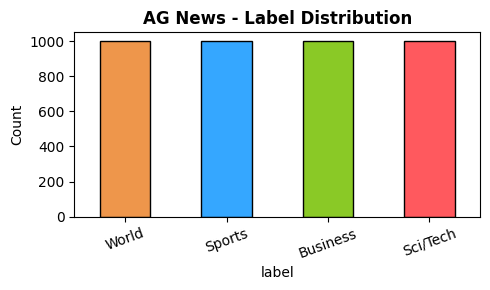

In [ ]:
# --- VISUALIZE LABEL DISTRIBUTION ---
plt.figure(figsize=(5,3))
label_names = ['World', 'Sports', 'Business', 'Sci/Tech']
small_df['label'].value_counts().sort_index().plot(kind='bar', color=['#ee964b', '#35a7ff', '#8ac926', '#ff595e'], edgecolor='black')
plt.xticks(ticks=range(4), labels=label_names, rotation=20)
plt.title('AG News - Label Distribution', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

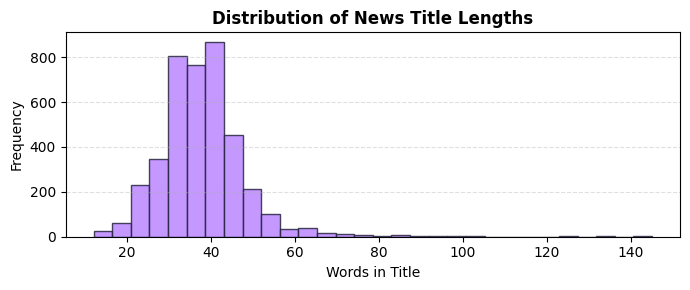

In [ ]:
# --- VISUALIZE NEWS TITLE LENGTHS ---
small_df['text_len'] = small_df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(7,3))
plt.hist(small_df['text_len'], bins=30, color='#b983ff', edgecolor='#22223b', alpha=0.83)
plt.title('Distribution of News Title Lengths', fontsize=12, fontweight='bold')
plt.xlabel('Words in Title')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

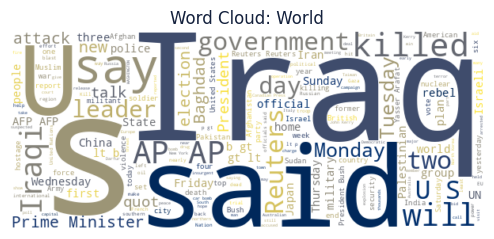

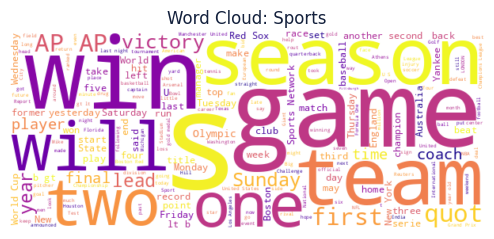

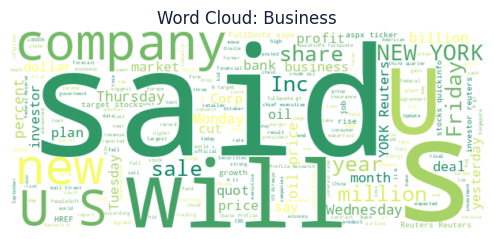

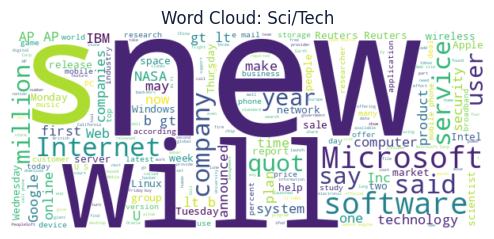

In [ ]:
# --- WORD CLOUDS FOR EACH CLASS ---
for class_id, class_name, cmap in zip(range(4), label_names, ['cividis', 'plasma', 'summer', 'viridis']):
    text_blob = " ".join(small_df[small_df['label']==class_id]['text'])
    wc = WordCloud(width=600, height=250, background_color='white', colormap=cmap).generate(text_blob)
    plt.figure(figsize=(7,2.5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud: {class_name}', fontsize=12, color='#14213d')
    plt.tight_layout()
    plt.show()

In [ ]:
# --- DATA PREP FOR MODEL ---
X_train = small_df['text'].tolist()
y_train = small_df['label'].tolist()
X_eval = small_test['text'].tolist()
y_eval = small_test['label'].tolist()

In [ ]:
# --- CUSTOM DATASET CLASS ---
class NewsBertSet(Dataset):
    def __init__(self, texts, targets, tokenizer, maxlen):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.maxlen = maxlen
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.maxlen,
            return_tensors='pt'
        )
        out = {k: v.squeeze(0) for k, v in enc.items()}
        out['labels'] = torch.tensor(self.targets[idx], dtype=torch.long)
        return out

In [ ]:
# --- TOKENIZER & DATALOADERS ---
ag_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 40

ds_train = NewsBertSet(X_train, y_train, ag_tokenizer, max_len)
ds_eval = NewsBertSet(X_eval, y_eval, ag_tokenizer, max_len)

loader_train = DataLoader(ds_train, batch_size=20, shuffle=True)
loader_eval = DataLoader(ds_eval, batch_size=20)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# --- MODEL, OPTIMIZER, LOSS ---
topic_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
topic_model = topic_model.to(dev)
optim_news = AdamW(topic_model.parameters(), lr=2e-5)
loss_news = nn.CrossEntropyLoss()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# --- SHOW SAMPLE INPUTS ---
print("\nAG News test samples and labels:\n")
for k in range(3):
    print(f"Title: {X_eval[k][:100]}...")
    print(f"True Label: {y_eval[k]} ({label_names[y_eval[k]]})")
    print()


AG News test samples and labels:

Title: Scientific Method Man Gordon Rugg cracked the 400-year-old mystery of the Voynich manuscript. Next u...
True Label: 3 (Sci/Tech)

Title: Brazil Recognizes China as a 'Market Economy' &lt;p&gt;&lt;/p&gt;&lt;p&gt; By Andrew Hay&lt;/p&gt;&l...
True Label: 0 (World)

Title: Integration champion enters open-source lists A new start-up offering certification, testing and dis...
True Label: 3 (Sci/Tech)



In [ ]:
# --- TRAINING LOOP ---
epochs_news = 10
news_losses = []

for ep in range(epochs_news):
    topic_model.train()
    ep_loss = 0
    for batch in loader_train:
        ids = batch['input_ids'].to(dev)
        mask = batch['attention_mask'].to(dev)
        labs = batch['labels'].to(dev)
        optim_news.zero_grad()
        output = topic_model(input_ids=ids, attention_mask=mask, labels=labs)
        loss = output.loss
        loss.backward()
        optim_news.step()
        ep_loss += loss.item()
    avg = ep_loss / len(loader_train)
    news_losses.append(avg)
    print(f"Epoch {ep+1}/{epochs_news} | Loss: {avg:.4f}")


Epoch 1/10 | Loss: 0.2966
Epoch 2/10 | Loss: 0.1735
Epoch 3/10 | Loss: 0.1049
Epoch 4/10 | Loss: 0.0592
Epoch 5/10 | Loss: 0.0293
Epoch 6/10 | Loss: 0.0196
Epoch 7/10 | Loss: 0.0171
Epoch 8/10 | Loss: 0.0084
Epoch 9/10 | Loss: 0.0236
Epoch 10/10 | Loss: 0.0180


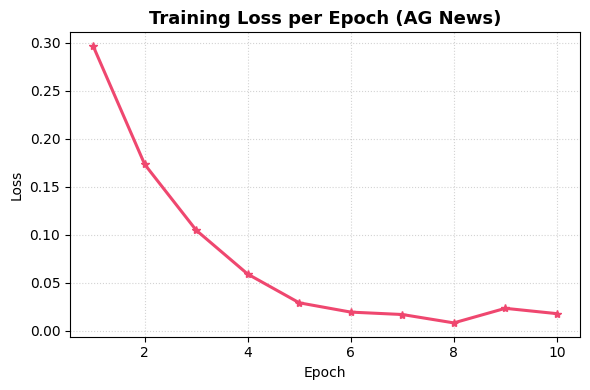

In [ ]:
# --- PLOT TRAINING LOSS ---
plt.figure(figsize=(6,4))
plt.plot(range(1, epochs_news+1), news_losses, marker='*', linestyle='-', color='#ef476f', linewidth=2.2)
plt.title('Training Loss per Epoch (AG News)', fontsize=13, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, linestyle=':', alpha=0.55)
plt.tight_layout()
plt.show()

In [ ]:
# --- EVALUATION ---
topic_model.eval()
news_preds, news_true = [], []

with torch.no_grad():
    for batch in loader_eval:
        ids = batch['input_ids'].to(dev)
        mask = batch['attention_mask'].to(dev)
        labs = batch['labels'].to(dev)
        outs = topic_model(input_ids=ids, attention_mask=mask)
        preds = torch.argmax(outs.logits, dim=1)
        news_preds.extend(preds.cpu().numpy())
        news_true.extend(labs.cpu().numpy())




AG News Test Accuracy: 0.8738
AG News Test F1 Score: 0.8724


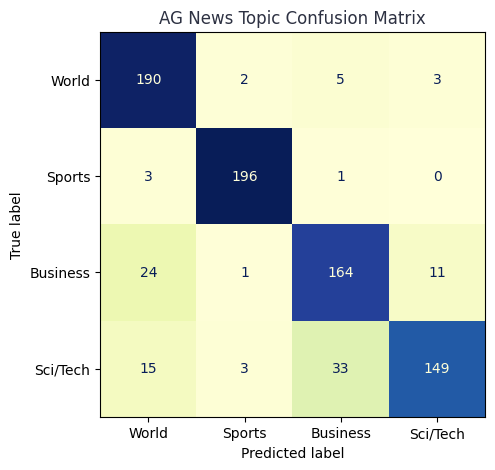

In [ ]:
acc_news = accuracy_score(news_true, news_preds)
f1_news = f1_score(news_true, news_preds, average='weighted')
print(f"\nAG News Test Accuracy: {acc_news:.4f}")
print(f"AG News Test F1 Score: {f1_news:.4f}")

cm_news = confusion_matrix(news_true, news_preds)
disp_news = ConfusionMatrixDisplay(confusion_matrix=cm_news, display_labels=label_names)
fig, ax = plt.subplots(figsize=(6,5))
disp_news.plot(cmap='YlGnBu', ax=ax, colorbar=False)
plt.title('AG News Topic Confusion Matrix', fontsize=12, color='#2d3142')
plt.show()


In [ ]:
# --- SHOW PREDICTIONS ---
print("\nPredictions on Test Samples:\n")
for k in range(5):
    print(f"Title: {X_eval[k][:100]}...")
    print(f"True: {label_names[y_eval[k]]} | Predicted: {label_names[news_preds[k]]}")
    print()


Predictions on Test Samples:

Title: Scientific Method Man Gordon Rugg cracked the 400-year-old mystery of the Voynich manuscript. Next u...
True: Sci/Tech | Predicted: Sci/Tech

Title: Brazil Recognizes China as a 'Market Economy' &lt;p&gt;&lt;/p&gt;&lt;p&gt; By Andrew Hay&lt;/p&gt;&l...
True: World | Predicted: World

Title: Integration champion enters open-source lists A new start-up offering certification, testing and dis...
True: Sci/Tech | Predicted: Sci/Tech

Title: Berlin Philharmonic to tour Japan for first time with Rattle (AFP) AFP - The Berlin Philharmonic and...
True: World | Predicted: World

Title: Guerrillas kill US soldier north of Baghdad BAGHDAD - Guerrillas attacked a US patrol north of Baghd...
True: World | Predicted: World

